# Rob's sandbox

---

# Imports

#### Python modules

In [46]:
import sys

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import (
    train_test_split,
    cross_val_score
)
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
%matplotlib inline

# Ancillary modules

#### Support adjustments

In [2]:
sys.path.append("../..")

#### Modules

In [3]:
%load_ext autoreload
%autoreload 2

from src.utils.params import (
    param_grid,
    max_features,
    n_estimators,
    cv_rounds,
    evaluation_metric,
    transformation_pickle_loc,
    fe_pickle_loc
)

from src.pipelines.ingestion import (
    ingest
)

from src.pipelines.transformation import (
    transform
)

from src.pipelines.feature_engineering import (
    load_transformation,
    feature_generation,
    feature_selection,
    save_fe,
    feature_engineering
)

from proyecto_1 import (
    main
)

---

# Tests

## Feature engineering

#### Loading transformation pickle

In [4]:
df = load_transformation("../../" + transformation_pickle_loc)

In [5]:
df

,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,label,dia_inicio,mes_inicio,anio_inicio,hora_inicio,min_inicio
0,23/01/2016,22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,0.0,23,01,2016,22.0,35
1,23/01/2016,22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,0.0,23,01,2016,22.0,50
2,24/01/2016,09:40:11,Domingo,(N) La unidad de atención a emergencias fue de...,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA_911_066,1.0,24,01,2016,9.0,40
3,24/01/2016,22:40:57,Domingo,(N) La unidad de atención a emergencias fue de...,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA_911_066,1.0,24,01,2016,22.0,40
4,24/01/2016,04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA_911_066,0.0,24,01,2016,4.0,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1383133,22/10/2020,16:17:05,Jueves,(A) La unidad de atención a emergencias fue de...,lesionado-atropellado,19.486310,-99.118120,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,0.0,22,10,2020,16.0,17
1383134,22/10/2020,16:29:13,Jueves,(A) La unidad de atención a emergencias fue de...,accidente-choque con lesionados,19.427274,-99.115814,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,0.0,22,10,2020,16.0,29
1383135,22/10/2020,12:00:26,Jueves,(D) El incidente reportado se registró en dos ...,accidente-choque sin lesionados,19.467180,-99.175250,EMERGENCIA,LLAMADA_911_066,0.0,22,10,2020,12.0,00
1383136,22/10/2020,12:01:25,Jueves,(D) El incidente reportado se registró en dos ...,accidente-choque con lesionados,19.427280,-99.096860,URGENCIAS MEDICAS,LLAMADA_911_066,0.0,22,10,2020,12.0,01


#### Processing data for model

In [18]:
df_features_prc, df_labels = feature_generation(df)


++ List of categorical variables that will be processed through the pipeline (4) are:
    1. codigo_cierre
    2. incidente_c4
    3. clas_con_f_alarma
    4. tipo_entrada


#### Training, executing and evaluating model

In [19]:
model = RandomForestClassifier(max_features=max_features, n_estimators=n_estimators)

In [20]:
model.fit(df_features_prc, df_labels)

RandomForestClassifier(max_features=6)

In [21]:
cv_scores = cross_val_score(
    model,
    df_features_prc,
    df_labels,
    scoring=evaluation_metric,
    cv=cv_rounds
)

print("\n++ Model performance metrics:\n")
print("    ++++ Cross validation scores:")
i = 1
for cvs in list(cv_scores):
    print("        Round {} -> {}".format(i, cvs))
    i += 1
print("\n")
print("    ++++ Cross validation mean score: {} \n".format(cv_scores.mean()))
print("    ++++ Cross validation score standard deviation: ", cv_scores.std())

Scores: [1.         1.         0.99999277 1.         1.         1.
 1.         1.         1.         1.        ]
Mean: 0.999999277007389
Standard deviation: 2.168977833039154e-06


#### Identifying most important variables

In [44]:
result = permutation_importance(
    model, 
    df_features_prc.toarray(), 
    df_labels, 
    n_repeats=2,
    random_state=42, 
    n_jobs=2
)

sorted_idx = result.importances_mean.argsort()

IndexError: index 21 is out of bounds for axis 0 with size 15

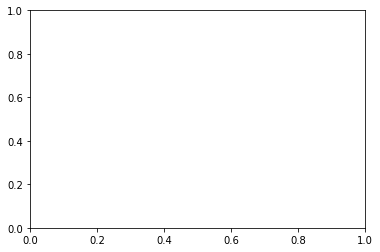

In [56]:
fig, ax = plt.subplots()

ax.boxplot(
    result.importances[sorted_idx].T,
    vert=False, 
    labels=df.columns[sorted_idx]
)

ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

---
---